# RK(3,2)-FB FBFC Analysis (CFL Optimization)

*FBFC = Forward-backward feedback coefficients*

Consider a simple model problem:
\begin{align*}
    \frac{\partial \zeta}{\partial t} &= -c \frac{\partial u}{\partial x}, \\
    \frac{\partial u}{\partial t} &= -c \frac{\partial \zeta}{\partial x}.
\end{align*}
Note that this is similar to the 1D linearized SWEs with the Coriolis term deleted.

With the goal of applying a von Neumann stability anaysis, we can apply a Fourier transform in $x$ to the above to get
\begin{align*}
    \frac{\partial \hat{\zeta}}{\partial t} &= -i \omega \hat{u}, \\
    \frac{\partial \hat{u}}{\partial t} &= -i \omega \hat{\zeta},
\end{align*}
where $\omega = ck$ for a given wavenumber $k$. Also, from now on, write $u = \hat{u}$ and $\zeta = \hat{\zeta}$ to ease notation.

Chose a time-step $\Delta t$ and let $\alpha = \omega\Delta t = ck\Delta t$. The RK(3,2)-FB algorithm for this system is then given by:
\begin{align*}
    \bar{\zeta}^{n+1/3} &= \zeta^n - \frac{i \alpha}{3} u^n \\
    \bar{u}^{n+1/3} &= u^n - \frac{i \alpha}{3} \left( \beta_1\bar{\zeta}^{n+1/3} + (1 - \beta_1)\zeta^n \right) \\
    & \\
    \bar{\zeta}^{n+1/2} &= \zeta^n - \frac{i \alpha}{2} \bar{u}^{n+1/3} \\
    \bar{u}^{n+1/2} &= u^n - \frac{i \alpha}{2} \left( \beta_2 \bar{\zeta}^{n+1/2} + (1 - \beta_2)\zeta^n \right), \\
    & \\
    \zeta^{n+1} &= \zeta^n - i \alpha \bar{u}^{n+1/2} \\
    u^{n+1} &= u^n -i \alpha \left( \beta_3\zeta^{n+1} + (1-2\beta_3)\bar{\zeta}^{n+1/2} + \beta_3\zeta^n \right)
\end{align*}
where $\beta_i$ for $i = 1, 2, 3$, are the tunable FB feedback coefficients.

In [1]:
from sympy import *
from scipy.optimize import minimize, NonlinearConstraint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# define relevent symbols 
#     _u = u^n, _zeta = \zeta^n
#     U1 = \bar{u}^{n+1/3}, ZETA1= \bar{\zeta}^{n+1/3}
#     U2 = \bar{u}^{n+1/2}, ZETA2= \bar{\zeta}^{n+1/2}
#     u = u^{n+1}, zeta = \zeta^{n+1}
_u, _zeta = symbols('u^n \zeta^n')
lam, alpha, beta1, beta2, beta3 = symbols('lambda alpha beta_1 beta_2 beta_3')

# define time-stepping scheme
ZETA1 = _zeta - (I*alpha/3) * _u
U1 = _u - (I*alpha/3) * ( beta1*ZETA1 + (1-beta1)*_zeta )

ZETA2 = _zeta - (I*alpha/2) * U1 
U2 = _u - (I*alpha/2) * ( beta2*ZETA2 + (1-beta2)*_zeta )

zeta = _zeta - I*alpha*U2
u = _u - I*alpha * ( beta3*zeta + (1-2*beta3)*ZETA2 + beta3*_zeta )

# simplify the expressions for zeta and u 
zeta  = zeta.simplify()
u = u.simplify()

Now, we have a system of linear equations in $\zeta^n$ and $u^n$. We can find the amplification matrix for the scheme by writing it in the form
$$ \mathbf{w}^{n+1} = G \mathbf{w}^n, $$
where $G$ is the amplification matrix and $\mathbf{w}^* = (\zeta^*, u^*)^T$.

We care about the amplification matrix $G$ as it follows from the above that $\mathbf{w}^n = G^n \mathbf{w}^0$. In turn, it follows that the solution $\mathbf{w}^n$ is bounded as $n \to \infty$ if and only if $||G^n||$ is bounded as $n \to \infty$.

In [2]:
# create the amplification matrix G
_w = [_zeta, _u]
w = [zeta, u]
G, _ = linear_eq_to_matrix(w, _w)

G

Matrix([
[                                        alpha**4*beta_2/12 - alpha**2/2 + 1,                                                                  -I*alpha**5*beta_1*beta_2/36 + I*alpha**3*beta_2/4 - I*alpha],
[-I*alpha**5*beta_2*beta_3/12 + I*alpha**3*beta_3/6 + I*alpha**3/6 - I*alpha, -alpha**6*beta_1*beta_2*beta_3/36 - alpha**4*beta_1*beta_3/9 + alpha**4*beta_1/18 + alpha**4*beta_2*beta_3/4 - alpha**2/2 + 1]])

Normally, we would now be interested in the eigenvalues of $G$ given that it can be shown that as long as $G$ is diagonalizable, then $||G^n||$ is bounded if and only if each eigenvalue $\lambda$ of $G$ is such that $|\lambda| \leq 1$.

However, we are first interesting in chosing the "optimal" FB feedback coefficients $\beta_i$.

To do this, we observe that we can write the orignal, Fourier transformed, system as
$$ \frac{\partial}{\partial t}\begin{pmatrix} \zeta \\ u \end{pmatrix} = \begin{pmatrix} 0 & -i\omega \\ -i\omega & 0 \end{pmatrix} \begin{pmatrix} \zeta \\ u \end{pmatrix}. $$

One can show that the general solution to the system is
$$ \begin{pmatrix} \zeta(t) \\ u(t) \end{pmatrix} = e^{t \begin{pmatrix} 0 & -i\omega \\ -i\omega & 0 \end{pmatrix}} \begin{pmatrix} \zeta(0) \\ u(0) \end{pmatrix}, $$
and that eigenvalues of the matrix exponential above are
$$ \lambda = e^{\pm i \omega t}. $$
At time $t = \Delta t$, these eigenvalues are $e^{\pm i \alpha}$.

Our goal here is to find $\beta_i$ so that the admitable $\alpha$ is as large as possible while retaining stability. To do this, we are going to solve a numerical optimization problem.

Towards this end, first calculate the characteristic polynomial of our amplification matrix $G$:

In [3]:
p = G.charpoly(lam).as_expr()
p.simplify()

-alpha**6*beta_1*beta_2*beta_3/36 + alpha**6*beta_1*beta_2/36 + alpha**6*beta_1*beta_3/18 - alpha**6*beta_1/36 - alpha**4*beta_1*beta_3/9 + alpha**4*beta_1/18 + alpha**4*beta_2*beta_3/4 - alpha**4*beta_2/6 - alpha**4*beta_3/6 + alpha**4/12 + lambda**2 - lambda*(-alpha**6*beta_1*beta_2*beta_3 - 4*alpha**4*beta_1*beta_3 + 2*alpha**4*beta_1 + 9*alpha**4*beta_2*beta_3 + 3*alpha**4*beta_2 - 36*alpha**2 + 72)/36 + 1

We have now have
$$ p(\alpha, \beta_1, \beta_2, \beta_3, \lambda) = 0. $$
Our goal is to choose $\beta_i$ so that $\alpha$ can be chosen as large as possible while the eigenvalues $\lambda = \lambda(\alpha, \beta_1, \beta_2, \beta_3)$ retain the property that $|\lambda| \leq 1$ as required for stability.

Call this desired value $\alpha_\text{max}$. To find this, we can solve a numerical optimization problem with the constarints given above, and a user-defined cost function (we will experiment with different choices for this).

To state the problem more formally, we wish to minimize the cost function
$$ C = C(\alpha_\text{max}, \beta_1, \beta_2, \beta_3) $$
subject to constraint:
$$ |\lambda(\alpha, \beta_1, \beta_2, \beta_3)| \leq 1 \qquad \forall \alpha \in \left(0, \alpha_\text{max}\right]. $$

In practice, we check this condition by checking the absolute value of the eigenvalues on a grid in $\alpha$, i.e. we check
$$ |\lambda(\alpha, \beta_1, \beta_2, \beta_3)| \leq 1 \qquad \forall \alpha = \delta, 2\delta, 3\delta, \cdots \alpha_\text{max}, $$
where $\delta$ is a user-defined step-size in `eigValMax()`, the smaller $\delta$ is, the longer the numerical optimization takes to execute.

In [4]:
# Require that |lambda| <= 1 for all 0 < alpha <= alpha_max
def eigValMax(x):
    step = np.pi/6
    absList = []
    for a in np.arange(step, x[0], step):
        vals = [ (alpha, a), (beta1, x[1]), (beta2, x[2]), (beta3, x[3]) ]
        eigVals = solve(p.subs(vals), lam)
        for eigVal in eigVals:
            absList.append( np.abs(complex(eigVal)) )
        # END for
    # END for
    return np.max(absList)
# END eigValCons()
nlEigValCons = NonlinearConstraint(eigValMax, 0, 1)
cons = [nlEigValCons]

# Define a function that gives a measure of how close the numerical eigenvalues are
# to their exact counterparts, we want this to be small for given alpha_max and beta_i
def eigValDiffSum(x):
    step = np.pi/6
    diff = 0
    diffs = []
    for a in np.arange(-np.pi/2, np.pi/2, step):
        vals = [ (alpha, a), (beta1, x[1]), (beta2, x[2]), (beta3, x[3]) ]
        approxEigVals = solve(p.subs(vals), lam)
        for approxEigVal in approxEigVals:
            diffs.append( np.abs( complex(exp(I*a).evalf()) - complex(approxEigVal) ) )
        # END for
        diff += np.min(diffs)
    # END for
    return diff
#END eigValDiffSum()

First, we try a simple cost function that seeks to maximize $\alpha_\text{max}$ while keeping the dissipation and dispersion error low:
$$ C(\alpha_\text{max}, \beta_1, \beta_2, \beta_3) = \frac{1}{\alpha_\text{max}} + \int_{\frac{-\pi}{2}}^{\frac{\pi}{2}} |\lambda_\text{exact}(\alpha) - \lambda(\alpha, \beta_1, \beta_2, \beta_3)|\ \text{d}\alpha. $$
Note that in practice, this integral term is implemented as a simple sum of the errors in the eigenvalues (see the definition of `eigValDiffSum()`).

Below, `x0` defines an initial guess for optimal parameters $(\alpha_\text{max}, \beta_1, \beta_2, \beta_3)$ -- unfortunately the results of the numerical optimization depend heavily on the choice of `x0`, maybe there is a way to fix this?

In [5]:
# define cost function
cost = lambda x: 1/x[0] + eigValDiffSum(x)

x0 = [3.5, 1/2, 1/2, 1/3]
bnds = [(3, 6), (0, 1), (0, 1), (0, 1)]
res = minimize(cost, x0, bounds=bnds, constraints=cons)
res

     fun: 0.25513639652493203
     jac: array([-0.05799394, -0.02644757,  0.6343754 ,  0.28585051])
 message: 'Optimization terminated successfully'
    nfev: 378
     nit: 47
    njev: 47
  status: 0
 success: True
       x: array([4.15249282, 0.54882035, 0.44256804, 0.36652374])

-4.71238898038469
-4.663301595172349
-4.614214209960009
-4.565126824747668
-4.516039439535327
-4.466952054322987
-4.417864669110647
-4.368777283898306
-4.319689898685965
-4.270602513473625
-4.221515128261284
-4.172427743048944
-4.123340357836604
-4.074252972624263
-4.025165587411922
-3.9760782021995817
-3.9269908169872414
-3.877903431774901
-3.8288160465625602
-3.77972866135022
-3.730641276137879
-3.6815538909255388
-3.5342917352885173
-3.485204350076177
-3.436116964863836
-3.3870295796514958
-3.3379421944391554
-3.2888548092268146
-3.2397674240144743


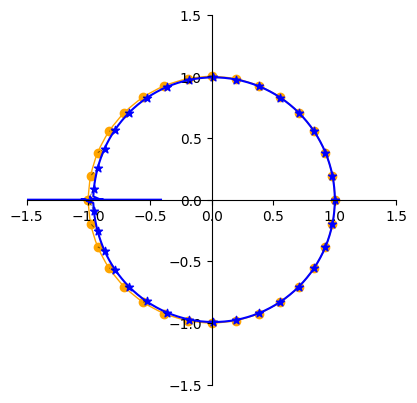

In [6]:
vals = res.x
optP = p.subs([(beta1, vals[1]), (beta2, vals[2]), (beta3, vals[3])])

fig, ax = plt.subplots(1)

ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')

axLim = 1.5
ax.set_xlim(-axLim, axLim)
ax.set_ylim(-axLim, axLim)
ax.set_aspect(1)

unitCircle = plt.Circle((0, 0), 1, fill=False, color='orange')
ax.add_artist(unitCircle)

approx_real = []
approx_imag = []
for k in np.arange(-24.0, 24.0, 0.25):
    # get complex values for exact and approx eigen values
    approx = complex( solve( optP.subs(alpha, k*pi/16), lam )[0 if k <= 0 else 1] )
    exact = complex( exp(I*k*pi/16).evalf() )
    approx_real.append( approx.real )
    approx_imag.append( approx.imag )
    
    if sqrt(approx.real**2 + approx.imag**2) > 1:
        print(k*np.pi/16)

    if k % 1 == 0 and np.abs(k) <= 16:
        # plot exact and approx eigen values
        colo = 'blue' if sqrt(approx.real**2 + approx.imag**2) <= 1 else 'red'
        ax.scatter(exact.real, exact.imag, marker='o', color='orange')
        ax.scatter(approx.real, approx.imag, marker='*', color=colo)
        # connect exact to approx with dashed line
        reals = [approx.real, exact.real]
        imags = [approx.imag, exact.imag]
        ax.plot(reals, imags, color='black', linestyle='dashed', linewidth=0.75, alpha=0.5)
# END for
ax.plot(approx_real, approx_imag, color='blue')

In [10]:
print(solve(optP.subs([(lam, -1)]), alpha))

[-5.99107535663530, 5.99107535663530, -2.72831607750989 - 0.690247554902163*I, -2.72831607750989 + 0.690247554902163*I, 2.72831607750989 - 0.690247554902163*I, 2.72831607750989 + 0.690247554902163*I]


In the above, we have
$$\alpha_\text{max} \approx 3.21, $$
not as good as Darren's experimental FBFCs. However, it seems that the dispersion/dissipation errors are much lower up until the point where stability is lost (`dt ~ 185.0` in `swe-python`). Worth thinking about this trade off, maybe some experiments comparing errors in practice? How confident are we that the experimental FBFCs are giving good results?

Let's try a different cost function, where we ignore any consideration of dispersion/dissipation errors:
$$ C(\alpha_\text{max}, \beta_1, \beta_2, \beta_3) = \frac{1}{\alpha_\text{max}} $$

In [8]:
# define cost function
cost = lambda x: 1/x[0]

x0 = [3.5, 1/2, 1/2, 1/3]
bnds = [(3, 6), (0, 1), (0, 1), (0, 1)]
res = minimize(cost, x0, bounds=bnds, constraints=cons)
res

     fun: 0.16666666666666666
     jac: array([-0.02777778,  0.        ,  0.        ,  0.        ])
 message: 'Iteration limit reached'
    nfev: 1125
     nit: 100
    njev: 100
  status: 9
 success: False
       x: array([6.        , 0.44147148, 0.53251603, 0.34505174])

3.9269908169872414
3.9760782021995817
4.025165587411922
4.074252972624263
4.123340357836604
4.172427743048944
4.221515128261284
4.270602513473625
4.319689898685965
4.368777283898306
4.417864669110647
4.466952054322987
4.516039439535327
4.565126824747668
4.614214209960009
4.663301595172349


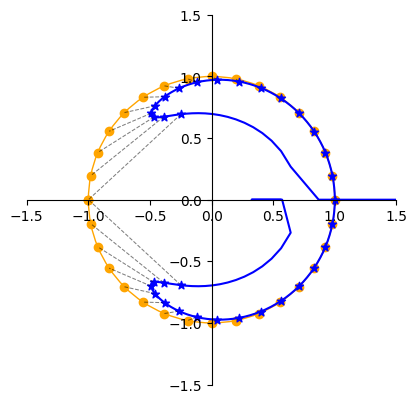

In [9]:
vals = res.x
optP = p.subs([(beta1, vals[1]), (beta2, vals[2]), (beta3, vals[3])])

fig, ax = plt.subplots(1)

ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')

axLim = 1.5
ax.set_xlim(-axLim, axLim)
ax.set_ylim(-axLim, axLim)
ax.set_aspect(1)

unitCircle = plt.Circle((0, 0), 1, fill=False, color='orange')
ax.add_artist(unitCircle)

approx_real = []
approx_imag = []
for k in np.arange(-24.0, 24.0, 0.25):
    # get complex values for exact and approx eigen values
    approx = complex( solve( optP.subs(alpha, k*pi/16), lam )[0 if k <= 0 else 1] )
    exact = complex( exp(I*k*pi/16).evalf() )
    approx_real.append( approx.real )
    approx_imag.append( approx.imag )
    
    if sqrt(approx.real**2 + approx.imag**2) > 1:
        print(k*np.pi/16)

    if k % 1 == 0 and np.abs(k) <= 16:
        # plot exact and approx eigen values
        colo = 'blue' if sqrt(approx.real**2 + approx.imag**2) <= 1 else 'red'
        ax.scatter(exact.real, exact.imag, marker='o', color='orange')
        ax.scatter(approx.real, approx.imag, marker='*', color=colo)
        # connect exact to approx with dashed line
        reals = [approx.real, exact.real]
        imags = [approx.imag, exact.imag]
        ax.plot(reals, imags, color='black', linestyle='dashed', linewidth=0.75, alpha=0.5)
# END for
ax.plot(approx_real, approx_imag, color='blue')

In [16]:
solve(optP.subs([(lam, 1)]), alpha)

[-6.43202980292160, -4.07235123654821, 0.0, 4.07235123654821, 6.43202980292160]

Here we have
$$ \alpha_\text{max} \approx 3.9 $$
which is larger than before, but the dispersion/dissipation errors are big for $\alpha > \frac{\pi}{2}$.

Trying a cost function that takes the dispersion/dissipation into account, but puts less weight on it:
$$ C(\alpha_\text{max}, \beta_1, \beta_2, \beta_3) = \frac{1}{\alpha_\text{max}} + \ln\left( \int_{\frac{-\pi}{2}}^{\frac{\pi}{2}} |\lambda_\text{exact}(\alpha) - \lambda(\alpha, \beta_1, \beta_2, \beta_3)|\ \text{d}\alpha \right). $$

In [12]:
# define cost function
cost = lambda x: 1/x[0] + np.log(eigValDiffSum(x))

x0 = [3.5, 1/2, 1/2, 1/3]
bnds = [(3, 6), (0, 1), (0, 1), (0, 1)]
res = minimize(cost, x0, bounds=bnds, constraints=cons)
res

     fun: -4.035508224653951
     jac: array([-0.05699325, -3.98511088, 23.1226936 , 19.32763684])
 message: 'Optimization terminated successfully'
    nfev: 274
     nit: 34
    njev: 34
  status: 0
 success: True
       x: array([4.18878904, 0.37857173, 0.4375219 , 0.35053977])

-3.0925052683774528
-3.043417883165112
4.074252972624263
4.123340357836604
4.172427743048944
4.221515128261284
4.270602513473625
4.319689898685965
4.368777283898306
4.417864669110647
4.466952054322987
4.516039439535327
4.565126824747668
4.614214209960009
4.663301595172349


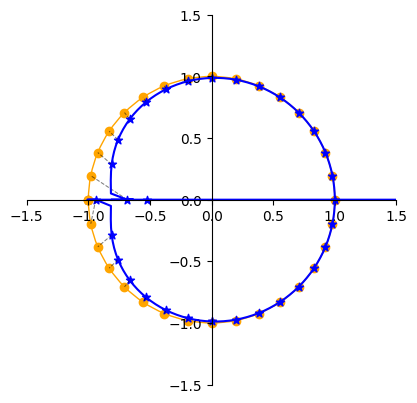

In [13]:
vals = res.x
optP = p.subs([(beta1, vals[1]), (beta2, vals[2]), (beta3, vals[3])])

fig, ax = plt.subplots(1)

ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')

axLim = 1.5
ax.set_xlim(-axLim, axLim)
ax.set_ylim(-axLim, axLim)
ax.set_aspect(1)

unitCircle = plt.Circle((0, 0), 1, fill=False, color='orange')
ax.add_artist(unitCircle)

approx_real = []
approx_imag = []
for k in np.arange(-24.0, 24.0, 0.25):
    # get complex values for exact and approx eigen values
    approx = complex( solve( optP.subs(alpha, k*pi/16), lam )[0 if k <= 0 else 1] )
    exact = complex( exp(I*k*pi/16).evalf() )
    approx_real.append( approx.real )
    approx_imag.append( approx.imag )
    
    if sqrt(approx.real**2 + approx.imag**2) > 1:
        print(k*np.pi/16)

    if k % 1 == 0 and np.abs(k) <= 16:
        # plot exact and approx eigen values
        colo = 'blue' if sqrt(approx.real**2 + approx.imag**2) <= 1 else 'red'
        ax.scatter(exact.real, exact.imag, marker='o', color='orange')
        ax.scatter(approx.real, approx.imag, marker='*', color=colo)
        # connect exact to approx with dashed line
        reals = [approx.real, exact.real]
        imags = [approx.imag, exact.imag]
        ax.plot(reals, imags, color='black', linestyle='dashed', linewidth=0.75, alpha=0.5)
# END for
ax.plot(approx_real, approx_imag, color='blue')

This looks *very* close to what we might want, though we can see that the eigenvalues *just* leave the unit circle when $\alpha \approx 3.04$.

In [15]:
solve(optP.subs([(lam, -1)]), alpha)

[-4.98597899077145 + 3.47833930642706e-104*I,
 -3.14138002048527 - 3.7693843615613e-102*I,
 -3.03672604080737 + 3.97217511225284e-104*I,
 3.03672604080737 - 1.76258650314366e-101*I,
 3.14138002048527 + 2.7174631443814e-102*I,
 4.98597899077145 - 3.47833930642706e-104*I]

Maybe we can change the inital guess for this cost function to avoid this? We could probably also avoid this by lowering the $\delta$ in `eigValDiffSum()`, though this is slow (maybe try this later).

In [17]:
# define cost function
cost = lambda x: 1/x[0] + np.log(eigValDiffSum(x))

x0 = [4, 1/2, 1/2, 1/3]
bnds = [(3.5, 6), (0, 1), (0, 1), (0, 1)]
res = minimize(cost, x0, bounds=bnds, constraints=cons)
res

     fun: -3.9792724236494665
     jac: array([-0.04503164, -3.52342629, 24.03260779, 19.01155078])
 message: 'Iteration limit reached'
    nfev: 762
     nit: 100
    njev: 100
  status: 9
 success: False
       x: array([4.71238898, 0.38800435, 0.43630695, 0.35817913])

4.221515128261284
4.270602513473625
4.319689898685965
4.368777283898306
4.417864669110647
4.466952054322987
4.516039439535327
4.565126824747668
4.614214209960009
4.663301595172349


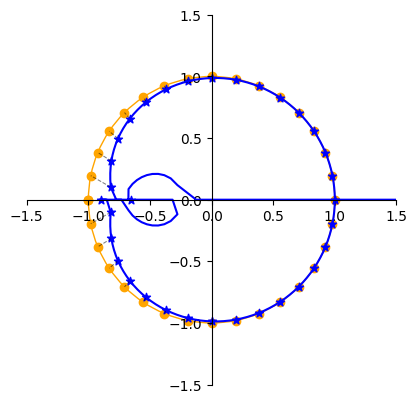

In [18]:
vals = res.x
optP = p.subs([(beta1, vals[1]), (beta2, vals[2]), (beta3, vals[3])])

fig, ax = plt.subplots(1)

ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')

axLim = 1.5
ax.set_xlim(-axLim, axLim)
ax.set_ylim(-axLim, axLim)
ax.set_aspect(1)

unitCircle = plt.Circle((0, 0), 1, fill=False, color='orange')
ax.add_artist(unitCircle)

approx_real = []
approx_imag = []
for k in np.arange(-24.0, 24.0, 0.25):
    # get complex values for exact and approx eigen values
    approx = complex( solve( optP.subs(alpha, k*pi/16), lam )[0 if k <= 0 else 1] )
    exact = complex( exp(I*k*pi/16).evalf() )
    approx_real.append( approx.real )
    approx_imag.append( approx.imag )
    
    if sqrt(approx.real**2 + approx.imag**2) > 1:
        print(k*np.pi/16)

    if k % 1 == 0 and np.abs(k) <= 16:
        # plot exact and approx eigen values
        colo = 'blue' if sqrt(approx.real**2 + approx.imag**2) <= 1 else 'red'
        ax.scatter(exact.real, exact.imag, marker='o', color='orange')
        ax.scatter(approx.real, approx.imag, marker='*', color=colo)
        # connect exact to approx with dashed line
        reals = [approx.real, exact.real]
        imags = [approx.imag, exact.imag]
        ax.plot(reals, imags, color='black', linestyle='dashed', linewidth=0.75, alpha=0.5)
# END for
ax.plot(approx_real, approx_imag, color='blue')

In [19]:
solve(optP.subs([(lam, 1)]), alpha)

[-5.84016669869682, -4.22121706992399, 0.0, 4.22121706992399, 5.84016669869682]

Here, we have
$$ \alpha_\text{max} \approx 4.22 $$
much better than the previous example (it is a shame that results depend so heavily on the choice of `x0`, it will be hard to be confident that we have a truly optimal set of FBFCs).

Testing this in `swe-python` we have a max time-step of `dt ~ 200.0`, smaller than the `dt ~ 216.0` allowed by the experimental FBFCs.

At this point, we've seen a few instances of FBFCs that give a larger $\alpha_\text{max}$ than that given by the experimental FBFCs have a smaller admitable time-step in practice (in `swe-python`). The optimization method used here is clearly not perfect, and I'd love to discuss ways to improve on it -- however, I think that the fact that we can't beat the experimental FBFCs with all this work means that we are trying to solve the "wrong" problem. 

We probably need to do this analysis in the linearized SWEs as Bob has pointed out previously. My thinking is that if the best FBFCs were chosen by testing in the SWEs, we might need to do the analysis on that problem to get better results.

I am concerned that the 2D linearized SWEs are going to create a problem too complex to solve using these tools -- we might need to think about adding some simpifying assumptions, like no dependence on `y`.